In [1]:
import geopandas as gpd
from osgeo import ogr
import pandas as pd
import tifffile as tiff #needed for the tif data for perry county
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.interpolate import griddata
from scipy import interpolate
from math import sin, cos, sqrt, atan2, radians
import sys
from shapely.geometry import Polygon, box, Point, LineString, MultiLineString
import pickle
import gurobipy as gp
from gurobipy import GRB
import tifffile as tiff #needed for the tif data for perry county
import xlwt
from xlwt import Workbook
from shapely.ops import snap, split, nearest_points
#from shapely.geometry import MultiPoint, LineString
#from dbfread import DBF
import osmnx as ox
import networkx as nx
import math
import gurobipy as gp
from gurobipy import GRB
import os
import csv
from sklearn.cluster import AgglomerativeClustering
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [2]:
# calculate distance
def haversinedist(lat1, lon1, lat2, lon2):
    R = 6373.0
    
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = R * c
    return distance #unit in km

In [3]:
# read data
def readClusterFile(fileID):
    file = np.genfromtxt(fileID, delimiter=",", skip_header = 1)
    file = file[:,1:]
    return file
clusterfile = 'Centralized_elevcluster' + str(1) + '.csv'

In [4]:
os.chdir("/Users/yuelanzhu/Downloads/Research/my code file")
# read data
def readClusterFile(fileID):
    file = np.genfromtxt(fileID, delimiter=",", skip_header = 1)
    file = file[:,1:]
    return file
clusterfile = 'Centralized_elevcluster' + str(1) + '.csv'
building_coords = readClusterFile(clusterfile)

In [5]:
# pipe parameters
pipesize = [0.05, 0.06, 0.08, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6] #m
pipesize_str, pipecost = gp.multidict({'0.05': 8.7, '0.06': 9.5, '0.08': 11, \
                                                   '0.1': 12.6, '0.15': 43.5,'0.2': 141, '0.25': 151, '0.3': 161, '0.35':230, '0.4': 246, '0.45':262, 
                                                   '0.5':292, '0.6':315}) #$/m
excavation = 25
bedding_cost_sq_ft = 6
capital_cost_pump_station = 1660#00
ps_flow_cost = 0.19
ps_OM_cost = 1759#50

In [6]:
# creat MST

graph = []
mstree = []
def createMSTnx(dataframe,n):
    #only takes longitude and latitude from the cluster data, note we also have elevation and stuff there too
    #coordinates = twoDcluster
    cluster = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    cluster.fit_predict(building_coords[:,1:2])
    # add cluster to dataframe
    dataframe['cluster.labels_'] = cluster.labels_.tolist()
    for k in range(n): 
        cluster_label = dataframe[dataframe['cluster.labels_'] == k]
        cluster_label = cluster_label[['longitude','latitude']]
        latlon = cluster_label.to_numpy()
        nrows, ncols = latlon.shape
        #creates graph
        graph.append(nx.Graph())
        weights = []
        #distance in km as weight between each point in the graph
        for i in range(nrows):
            graph[k].add_node(i,pos=(latlon[i,0],latlon[i,1]))
            for j in range(i+1,nrows):
                dist = haversinedist(latlon[i,1], latlon[i,0], latlon[j,1], latlon[j,0])
                weights.append(dist)
                graph[k].add_edge(i,j, weight = dist)
        #creates MST
        mstree.append(nx.minimum_spanning_tree(graph[k]))
    return mstree, graph

In [7]:
# create dataframe
df = pd.DataFrame(building_coords,
                  columns = ['longitude','latitude','elevation'])
# creat subnetworks
g_mst = createMSTnx(df,10)
# select 1 simple network
df0 = df[df['cluster.labels_'] == 0]

In [8]:
# set edge points of rectangle
points = np.array([[df0['longitude'].max(), df0['latitude'].min()], 
                   [df0['longitude'].max(), df0['latitude'].max()], 
                   [df0['longitude'].min(), df0['latitude'].min()], 
                   [df0['longitude'].min(), df0['latitude'].max()]])  
values = np.array([100, 50, 50, 0])  

In [9]:
# bilinear interpolation
for index, row in df0.iterrows(): 
    x = row['longitude']
    y = row['latitude']
    z = griddata(points, values, (x, y), method='linear')
    df0.loc[index,'elevation'] = z

In [10]:
def result(df, num_c, cluster_labels, pipesize, pipecost, water_demand, HLmax, excavation, bedding_cost_sq_ft, capital_cost_pump_station, ps_OM_cost):

    # select highest and lowest nodes in cluster
    tank = df.loc[df.groupby(['cluster.labels_'])['elevation'].idxmax()].reset_index(drop=True)
    trem = df.loc[df.groupby(['cluster.labels_'])['elevation'].idxmin()].reset_index(drop=True)
                      
     # find label of tank node in cluster
    tank_lon = str(tank[tank['cluster.labels_'] == cluster_labels][['longitude']].iat[0,0])
    tank_lat = str(tank[tank['cluster.labels_'] == cluster_labels][['latitude']].iat[0,0])
    global tank_node
    for i in mstree[cluster_labels].nodes():
        if str(mstree[cluster_labels].nodes[i]['pos'][0]) == tank_lon and str(mstree[cluster_labels].nodes[i]['pos'][1]) == tank_lat:
            tank_node = i                  
    #create flow direction dict
    links = list(mstree[cluster_labels].edges)
    flow_dir = {}
    for i,j in links:
        if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) < len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
        # if node i is nearer to tank
           flow_dir[i,j]=(i,j)
        if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) > len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
         # if node j is nearer to tank
           flow_dir[i,j]=(j,i) 
    # find nodes for inflow and outflow
    innode = {}
    outnode = {}
    for i,j in links:
        if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) > len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
           # if node j is nearer to tank
            innode.setdefault(i, [])
            innode[i].append(j)
            outnode.setdefault(j, [])
            outnode[j].append(i)
        else:
           # if node i is nearer to tank
            innode.setdefault(j, [])
            innode[j].append(i)
            outnode.setdefault(i, [])
            outnode[i].append(j)
    for i in mstree[cluster_labels].nodes():
        innode.setdefault(i,[])
        outnode.setdefault(i, [])
   # directed graph
    mstree_dir = nx.DiGraph()
    mstree_dir.add_nodes_from(mstree[cluster_labels])
    mstree_dir.add_edges_from(flow_dir.values())
    weights = {}
    for i in list(mstree_dir.edges()):
        weights[i] = None
    for i,j in flow_dir:
        if flow_dir[i,j]==(i,j):
            weights[i,j]=mstree[cluster_labels].edges[i,j]['weight']
        if flow_dir[i,j]==(j,i):
            weights[j,i]=mstree[cluster_labels].edges[i,j]['weight']
    nx.set_edge_attributes(mstree_dir, values = 1, name = 'weight')
    nx.set_edge_attributes(mstree_dir, values = weights, name = 'weight')
    # determine iterate order
    walk = {}
    for i,j in mstree_dir.edges():
        walk[i,j] = len(nx.shortest_path(mstree_dir ,source=tank_node, target=j))
    sorted_walk = dict(sorted(walk.items(), key=lambda item: item[1], reverse = True))
    # pipe flow
    pipe_flow = {}
    for i,j in sorted_walk:
        if len(outnode[j]) == 0:
            pipe_flow[i,j] = water_demand
        else:
            pipe_flow[i,j] = sum(pipe_flow[m,n] for m,n in sorted_walk if m == j) + water_demand #250gpd to 1.095E-5m3/s
    # head loss at largest dia        
    head_loss = {}
    for i in list(mstree_dir.edges()):
        head_loss[i] = None
    for i,j in list(mstree_dir.edges()):
        head_loss[i,j] = 10700*(pipe_flow[i,j]/140)**1.852*0.6*1000*mstree_dir[i][j]["weight"]
    # flow, distance and head loss for each edge
    edge_list = {}
    for i,j in links:
        if (i,j) == flow_dir[i,j]:
            edge_list[i,j] =[pipe_flow[i,j],mstree[cluster_labels][i][j]["weight"], head_loss[i,j]]
        else:
            edge_list[j,i] =[pipe_flow[j,i],mstree[cluster_labels][i][j]["weight"], head_loss[j,i]]
   #node elevation excavation in meters
   #upper bound is arbritrary maximum depth assuming 1 foot or 0.3048 meters of cover beneath the surface is needed for the pipes
   #a lower bound variable is created but not used. In future models might need to implement that depending on the site (digging too deep for excavation is not feasible for many projects)
    cluster = df[df['cluster.labels_'] == cluster_labels]
    cluster_elv = cluster[['elevation']]
    elevation_ub = dict()
    elevation_lb = dict()
    for i in range(len(cluster_elv)):
        GE=float(str(cluster_elv.values.tolist()[i])[1:-1])
        elevation_ub[i] = GE - 0.3
        elevation_lb[i] = GE - 30 #10 m
    GE=[]
    for i in range(len(cluster_elv)):
        GE.append(float(str(cluster_elv.values.tolist()[i])[1:-1]))
    #for i in range(mstree[cluster_labels].number_of_nodes()):
        #elevation_ub[i] = cluster_elv.iloc[[0]] - 0.3048
        #elevation_lb[i] = cluster_elv.iloc[[0]] - 30
        
    m = gp.Model('pipe and pump distribution')
    m.Params.timeLimit = 12000
   # binary variable indicating if at link ij pipe of diameter k is implemented
    d = m.addVars(mstree_dir.edges(), pipesize, vtype = GRB.BINARY, name = "diameter")
   #continuous variable representing the hydro loss in link ij.
    HL = m.addVars(mstree_dir.edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "hydro loss")
    # hydro gradient
    #J = m.addVars(mstree[cluster_labels].edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "hydro gradient")
   # binary variable indicating if at link ij the pump of type m is implemented.
    p = m.addVars(mstree_dir.edges(), vtype = GRB.BINARY, name = "PUMP")
   #continuous variable representing the pressure injected by the pump at link ij.
    pr = m.addVars(mstree_dir.edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "PRESSURE BY PUMP")
   #pipe elevations at node i 
    e = m.addVars(mstree_dir.nodes(), lb = 0, vtype = GRB.CONTINUOUS, name = 'In Node Elevation')
   #continuous variable representing the head pressure at node i
    H = m.addVars(mstree_dir.nodes(),lb = 0, vtype = GRB.CONTINUOUS, name = "HEAD PRESSURE")
   #Velocity
    v = m.addVars(mstree_dir.edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "Velocity")
    for i,j in mstree_dir.edges():
#Hazen Williams equation, A = 10700, C=140, P472
        #m.addConstr(J[i,j] == 
                #10700*(edge_list[i,j][0]/140)**1.852*gp.quicksum(d[i,j,k]/(k**4.8704) for k in pipesize)
               #, "Hydro loss")
        m.addConstr(HL[i,j] == 10700*(edge_list[i,j][0]/140)**1.852*gp.quicksum(d[i,j,k]/(k**4.8704) for k in pipesize)*1000*mstree_dir[i][j]["weight"])
        m.addConstr(HL[i,j] <= HLmax)
#only one pipe per edge
        m.addConstr((d.sum(i, j, '*') == 1.0), "single size chosen") 
    
#only one pump per edge
        m.addConstr((p.sum(i, j, '*') <= 1.0), "single type chosen")
    
#injected pressure pr[i,j] must be less than a huge number.
        #m.addConstr(pr[i,j]<=p[i,j]*10**6)
    
    # injected pressure pr[i,j] must be less than the capacity of pump.
        m.addConstr(pr[i,j] <= p[i,j]*100, "pressure by pump less than 100 m ")
    # energy requirement
        m.addConstr(H[j] == H[i] - HL[i,j] + e[i] - e[j] + pr[i,j], "Energy balance")
    
        #if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) < len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
        # if node i is nearer to tank        
            #m.addConstr(H[j] == H[i] -HL[i,j] + e[i] - e[j] + pr[i,j], "Energy balance")
        #if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) > len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
        # if node j is nearer to tank        
            #m.addConstr(H[i] == H[j] -HL[i,j] + e[j] - e[i] + pr[i,j], "Energy balance")
    # Velocity must be between 0.6 and 3 m/s to 30
        m.addConstr(v[i,j] * (3.14/4)*gp.quicksum(d[i,j,k]*k**2 for k in pipesize) == edge_list[i,j][0], "VA=Q")
        m.addConstr(v[i,j] <= 3, 'Vmax')
        m.addConstr(v[i,j] >= 0.001, 'Vmin') # Vmin must be very small or it will get errors
        #m.addConstr((
           #edge_list[i,j][0] <= ((3.14/4)*gp.quicksum(d[i,j,k]*k**2 for k in pipesize)) * 3), "Velocity Max Constr"+ str([i,j]))
        #m.addConstr((
           #edge_list[i,j][0] >= ((3.14/4)*gp.quicksum(d[i,j,k]*k**2 for k in pipesize)) * 0.6), "Velocity Min Constr" + str([i,j]))  
    for i in range(len(cluster_elv)):
#pipe elevation must be betwenn lb and ub
        m.addConstr(e[i] >= elevation_lb[i], "PIPE ELV LB")
        m.addConstr(e[i] <= elevation_ub[i], "PIPE ELV UB")
    
        m.addConstr(H[i] >= 31.646232670592248, "Min head pressure") #45 psi, covert it to m
        m.addConstr(H[i] <= 56.26, "Max head pressure") #80 psi, covert it to m   
        
        
    #m.addConstr(H[tank_node] == 31.646232670592248)                
                      
    # pipe cost 
    obj1 = gp.quicksum(1000 * mstree_dir[i][j]["weight"] * gp.quicksum(pipecost[str(k)] * d[i, j, k] 
                                                           for k in pipesize) for i,j in mstree_dir.edges())
    
    # Capital cost of pump stations
    obj2 = gp.quicksum(p.sum(i, j) * (capital_cost_pump_station + ps_flow_cost*edge_list[i,j][0]) for i,j in mstree_dir.edges())
    #Operation and maintenance costs
    obj3 = gp.quicksum(p.sum(i, j)*ps_OM_cost for i, j in mstree_dir.edges())
    # Excavation cost
    obj4 = gp.quicksum((1 + gp.quicksum(d[i,j,k]*k for k in pipesize)) *1000* mstree_dir[i][j]["weight"] * bedding_cost_sq_ft + excavation * \
                               (1 + gp.quicksum(d[i,j,k]*k for k in pipesize)) *1000* mstree_dir[i][j]["weight"] * 0.5 * ((GE[i] - e[i]) + (GE[j] - e[j])) for i, j in mstree_dir.edges())

    # Capital cost of pump stations
    #obj2 = gp.quicksum(1000 * mstree_dir[i][j]["weight"] * gp.quicksum(pumpcost[pumptype.index(m)] * p[i, j, m] 
                                                           #for m in pumptype) for i,j in mstree_dir.edges()) #+penalty

    #Operation and maintenance costs
    #obj3 = gp.quicksum(p.sum(i, j)*ps_OM_cost for i, j in mstree_dir.edges())

    obj = obj1+obj2+obj3+obj4                  
    m.setObjective(obj, GRB.MINIMIZE)
    m.optimize()
    
    # diameter
    diameter = { k : v.X for k,v in d.items()}
    diameter = { k : v.X for k,v in d.items() if v.X == 1}
    diameter = list(diameter.keys())
    d = []
    for i in range(len(diameter)):
        d.append(diameter[i][2])
        
    # pump
    pump = { k : v.X for k,v in p.items() if v.X ==1}
    pump = list(pump.keys())
    p = [x[0] for x in pump]
    color_map = []
    for node in mstree[cluster_labels]:
        if node in p:
            color_map.append('blue')
        else: 
            color_map.append('c')
        if node == tank_node:
            color_map[node]=('red') 

            
    #Hydro loss
    hydro_loss = { k : v.X for k,v in HL.items()}

    
    #elev
    ele = { k : v.X for k,v in e.items()}
    
    #head pressure
    h = { k : v.X for k,v in H.items()}
    
    #velocity
    v = { k : v.X for k,v in v.items()}
        
    
    return d, color_map, diameter, edge_list, hydro_loss, ele, h, v

In [11]:
# model run
output = result(df0, 1, 0, pipesize, pipecost, 1.095E-5, 1e+5, excavation, bedding_cost_sq_ft, capital_cost_pump_station, ps_OM_cost)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-14
Set parameter TimeLimit to value 12000
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 976 rows, 1541 columns and 3487 nonzeros
Model fingerprint: 0xa01da407
Model has 2106 quadratic objective terms
Model has 81 quadratic constraints
Variable types: 407 continuous, 1134 integer (1134 binary)
Coefficient statistics:
  Matrix range     [2e-07, 5e+03]
  QMatrix range    [2e-03, 3e-01]
  Objective range  [3e+02, 1e+06]
  QObjective range [2e+01, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+05]
  QRHS range       [1e-05, 9e-04]
Presolve removed 733 rows and 483 columns
Presolve time: 0.02s
Presolved: 4881 rows, 3011 columns, 12900 nonzeros
Variable types: 2279 continuous, 732 integer (732 binary)
Found heuristic solution: objective 413892.31976

Root relaxation: 

In [12]:
# check missing value of pipe diameter
# sometimes an edge will get 2 selections of pipe size (when condition is v.X ==1) or get no selection (when condition is v.X != 0)
diaedge = []
for i in range(len(output[2])):
    diaedge.append((output[2][i][0],output[2][i][1]))
diff = list(set(list(output[3].keys()))-set(diaedge))
miss = list(output[3].keys()).index(diff[0])
output[0].insert(miss,0.05)

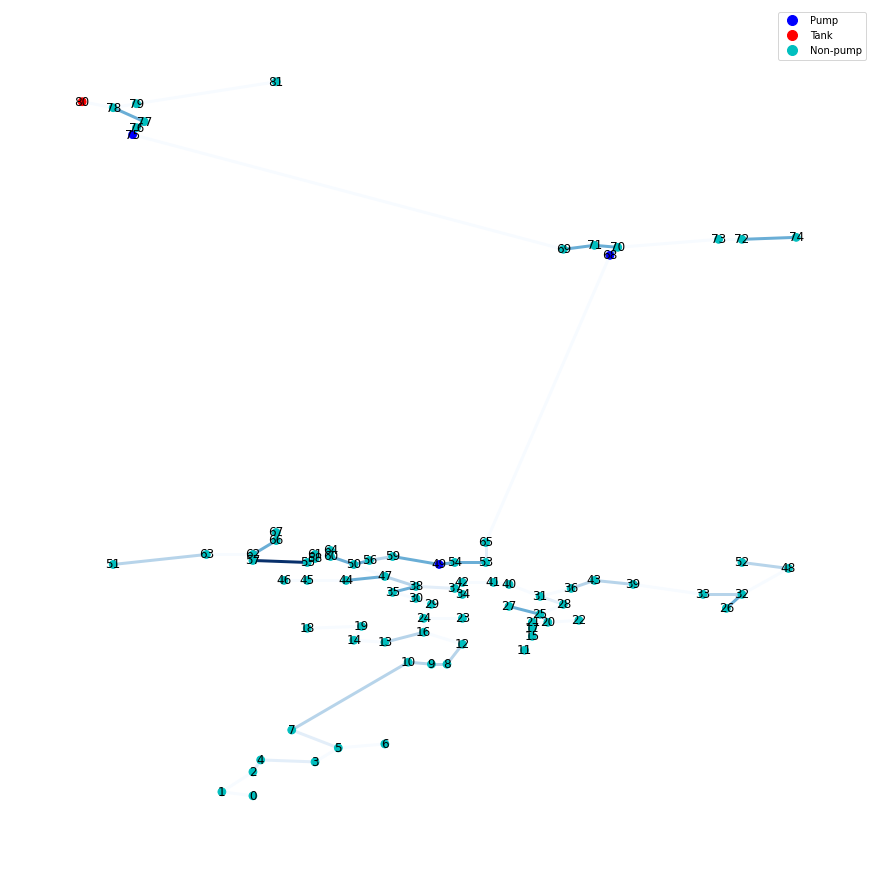

In [13]:
pos = {city:(long, lat) for (city, (lat,long)) in nx.get_node_attributes(g_mst[0][0], 'pos').items()}
plt.figure(3,figsize=(12,12)) 
nx.draw(g_mst[0][0], pos, with_labels=True, 
        node_size=60, node_color = output[1], 
        edgelist=g_mst[0][0].edges(),edge_color = output[0],
        edge_cmap=plt.cm.Blues, width=3)
# node legend
pump_patch = mlines.Line2D([], [], color='blue', marker='o', linestyle='None',
                          markersize=10, label='Pump')
tank_patch = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                          markersize=10, label='Tank')
nonpump_patch = mlines.Line2D([], [], color='c', marker='o', linestyle='None',
                          markersize=10, label='Non-pump')
plt.legend(handles=[pump_patch, tank_patch, nonpump_patch],fontsize=10)
#plt.title('The least cost system sizing for 1 subnework',fontsize=200)
plt.show()